# Local Classifier 2 Sample Tests (C2ST) applied to JRNMM
See `Local_C2ST_example_1D_lampe.ipynb` for the theoretical context, motivation and methodology of this method. 

We here apply the L-C2ST validation method to a real SBI example in computational neuroscience: the Jansen & Rit Neural Mass Model.



**SBI-setting:**
- Prior: `torch.Size([1, 4])`
    $$p(\theta) = \mathcal{U}([10,250], [50,500], [100,5000],[-20,20])$$
- Simualtor (JR-NMM): `torch.Size([1, 1024])`
    $$\text{Simulator}(\theta) = x \sim p(x\mid \theta) \text{, where} \theta = (C, \mu, \sigma, g)$$
- Summary Statistics (Fourier log Power Spectral Density): `torch.Size([1, 33])`
    $$s(x) = \text{log-PSD}(x)$$
    For simplicity, we use the notation $x$ when we actually refer to $s(x)$.
    
**GOAL:** Evaluate the estimated posterior in an observation $x_0$ and check how close this approximation is to the true unknown true density $p(\theta \mid x_0)$. 

**METHOD:** Because we are in a multivariate case ($\theta$ does not live in 1D, but 4D), the local PIT [Zhao et al. (2021)] is not applicable. We will directly use our method, ***local C2ST***. 

In this notebook we directly load precomputed results (long running time), details can be found in the notebook `JRNMM.ipynb`.

### Density Estimator 
Normalizing Flow (MAF) with 10 layers $q_{\phi}(\theta\mid x) \approx p(\theta\mid x)$ trained on $50 000$ samples from the joint:
$$\theta_i \sim p(\theta), x_i = \text{Simulator}(\theta_i) \sim p(x \mid \theta_i) \quad \rightarrow \quad \theta_i,x_i \sim p(\theta, x)$$ 
We load the pretrained NF, obtained by running `script_margaret_trainHNPE_sim.py`.

In [8]:
filename = f'../saved_experiments/JR-NMM/posteriors_amortized/naive_posterior_nextra_0_single_rec_False_nsim_50000.pkl'
posterior_est = torch.load(filename)

### Evaluation of the trained estimator

#### Global consistency check
We here use a pre-simulated calibration set of size $10000$.

In [9]:
# Load simulated Data
filename = f"../saved_experiments/JR-NMM/datasets_naive_small.pkl"
datasets = torch.load(filename)
x_cal, theta_cal = datasets['B_prime']['x'], datasets['B_prime']['theta'] # 10_000
x_cal.shape, theta_cal.shape

(torch.Size([10000, 33, 1]), torch.Size([10000, 4]))

In [10]:
# compute inverse flow transform on cal set
import torch.distributions as D

inv_flow_values_cal = posterior_est._transform(theta_cal, context=x_cal)[0].detach()
norm_samples = D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((len(x_cal),))


In [5]:
# Compute Global c2st score
from sbi.utils.metrics import c2st_scores
scores = c2st_scores(inv_flow_values_cal, norm_samples, n_folds=10)
print('flow:', np.mean(scores).__round__(2), '+/-', np.std(scores).__round__(2))

flow: 0.54 +/- 0.01


This score shows that our estimator is not perfect, but the average performance is not too bad (0.55 is not too far from 0.5).

### Local Consistency

#### Observations x_0
The different observations $x_0$ are genreated via the simualtor from ground-truth parameters $\theta_0 = (C_0, \mu_0, \sigma_0, g_0)$ where only $g_0$ varies between $[-25,25]$.

**Intuition:** We expect that our estimator is better when evaluated at observations obtained from a $g_0$ within the prior range $[-20,20]$. As we get close to (or even outside) the borders of this uniform prior we expect inconsistent behavior. 


In [11]:
# ground-truth parameters to generate observation
# fixed_params
c = 135.0
mu = 220.0 
sigma = 2000.0
# different gain values 
gain_list = np.linspace(-25,25,11, dtype=int)

# Load pre-simulated observations
x_obs_list = torch.load('../saved_experiments/JR-NMM/normal_4d/gt_observations/nextra_0/gain_experiment_new.pkl')[1]
theta_obs_list = gain_list
x_obs_list.shape

torch.Size([11, 33, 1])

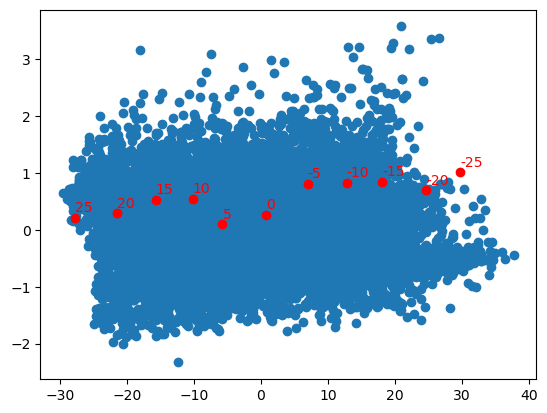

In [7]:
# Visualize observations with calibration dataset via PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_cal[:,:,0]) 
x_new = pca.transform(x_cal[:,:,0])

plt.scatter(x_new[:,0],x_new[:,1])
x_new_obs = pca.transform(x_obs_list[:,:,0])
plt.scatter(x_new_obs[:,0],x_new_obs[:,1], color='red')
for i,g in enumerate(gain_list):
    plt.text(x_new_obs[i,0],x_new_obs[i,1]+0.1, str(g), color='red')
plt.show()

#### Local C2ST at $x_0$
We show results obtained for the `MLPClassifier` (with hyperparameters defined in `sbi.utils.metrics`) and for a calibration set of size 12500 (as motivated in the section about the classifier and cal-set choice, 10000 is not enough to get accurate test results).

Results were pre-computed by running `script_margaret_local_c2st.py` with the right set-up.

##### Predict probas at $x_0$

In [13]:
# Load pre-computed results 
probas = []
probas_null = []

for g in gain_list:
    probas.append(torch.load(f'../saved_experiments/JR-NMM/normal_4d/lc2st_results/12500/probas_jrnmm_g_{g}.pkl'))
    probas_null.append(torch.load(f'../saved_experiments/JR-NMM/normal_4d/lc2st_results/12500/probas_null_g_{g}.pkl'))

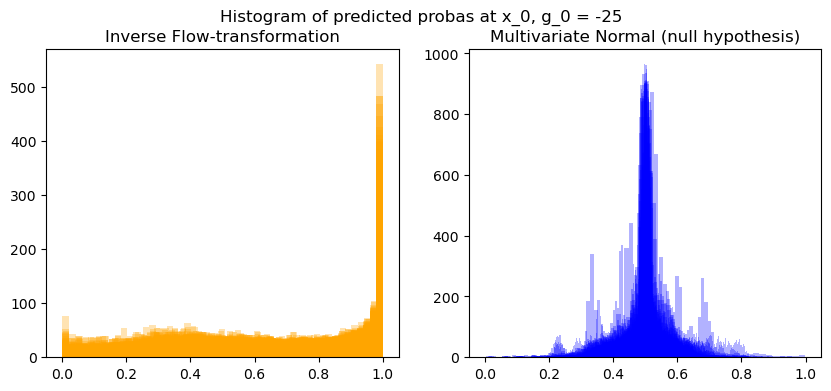

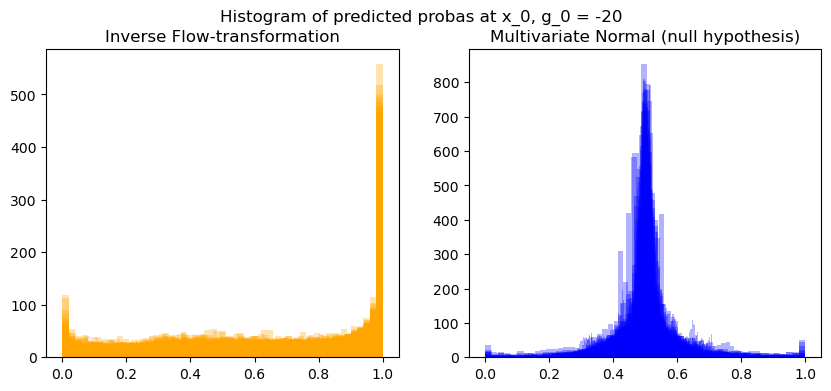

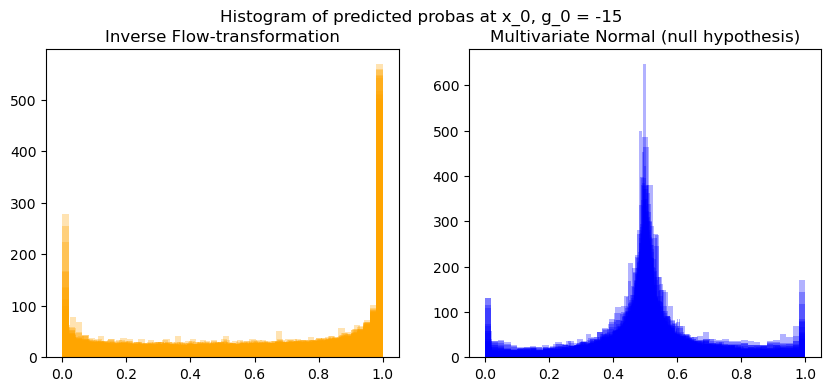

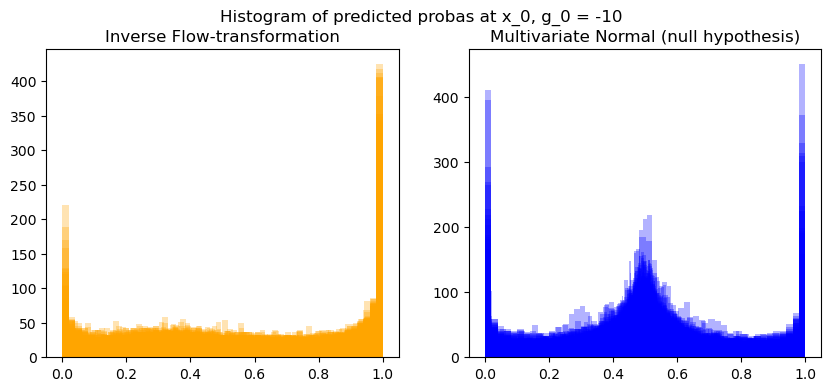

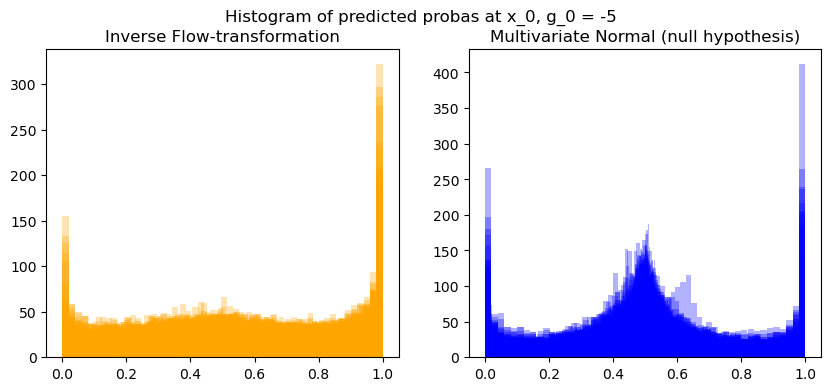

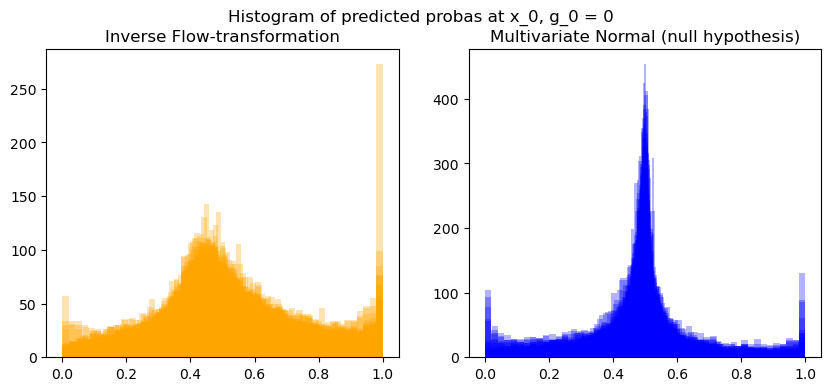

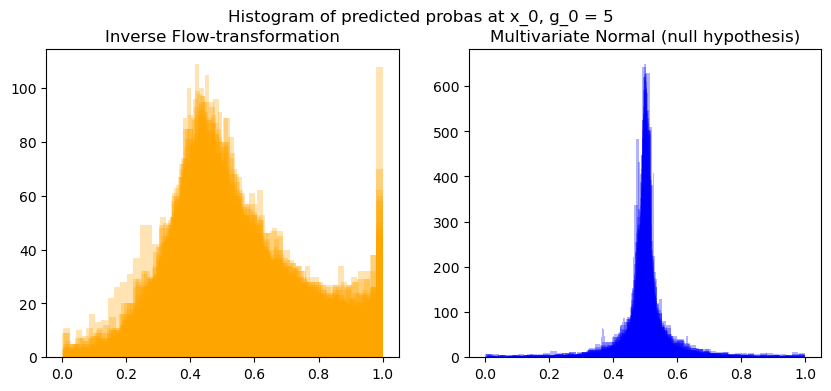

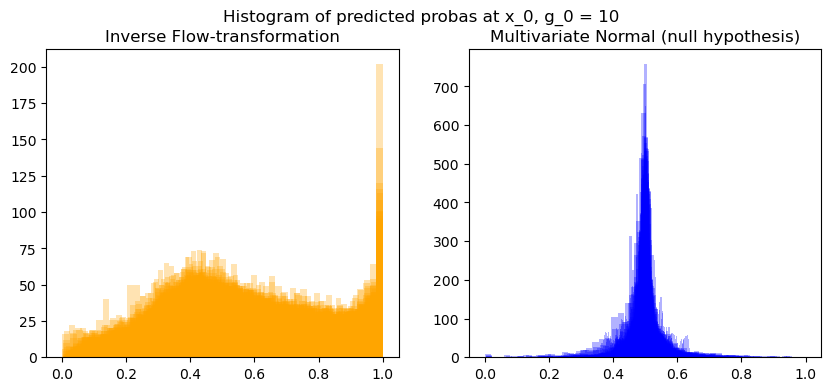

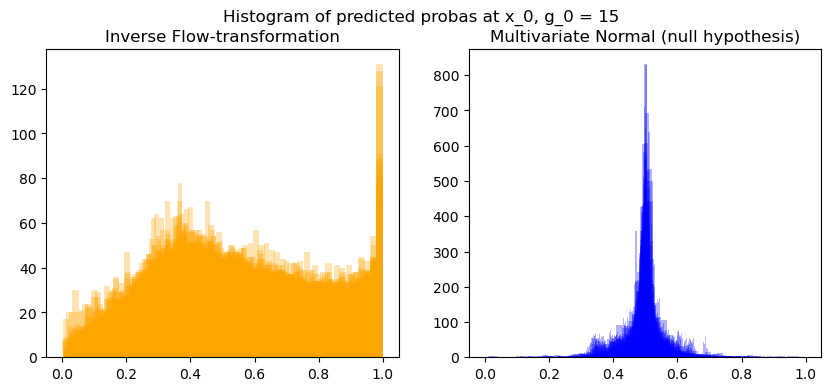

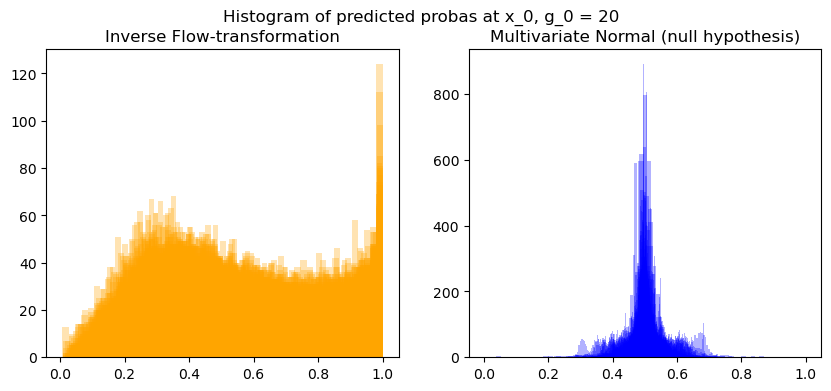

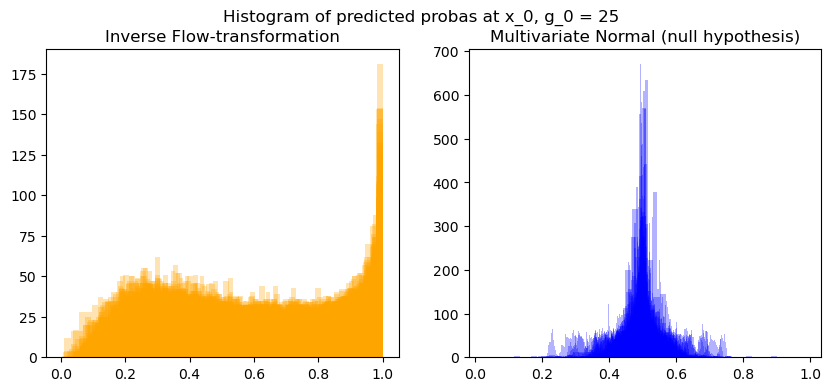

In [14]:
# Plot histograms
n_trials = 1000

plt.rcParams["figure.figsize"] = (10, 4)
for i,g in enumerate(gain_list):
    fig, axs = plt.subplots(1,2)
    for t in range(n_trials):
        axs[0].hist(probas[i][t], alpha=0.3, bins=50, color='orange')
        axs[1].hist(probas_null[i][t], alpha=0.3, bins=50, color='blue')
    axs[0].set_title('Inverse Flow-transformation')
    axs[1].set_title('Multivariate Normal (null hypothesis)')
    plt.suptitle(f'Histogram of predicted probas at x_0, g_0 = {g}')
    plt.show()

##### Hypothesis Test Diagnostics (at confidence level of 95%)


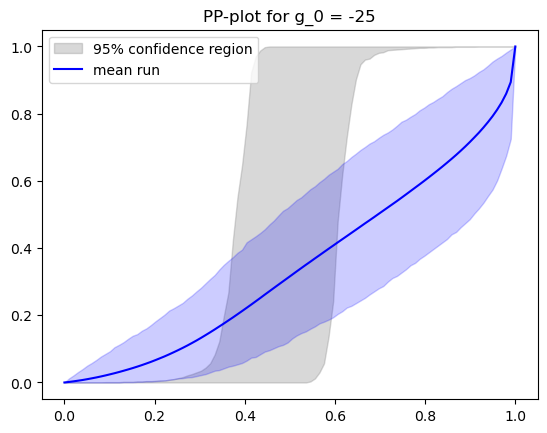

NB samples = 12500
std 0.025448661837384
test stat:  0.11646652201901 w_dist:  0.2754344466194824
p-value:  0.039 p_value_w:  0.001
rejected
rejected (w_dist)


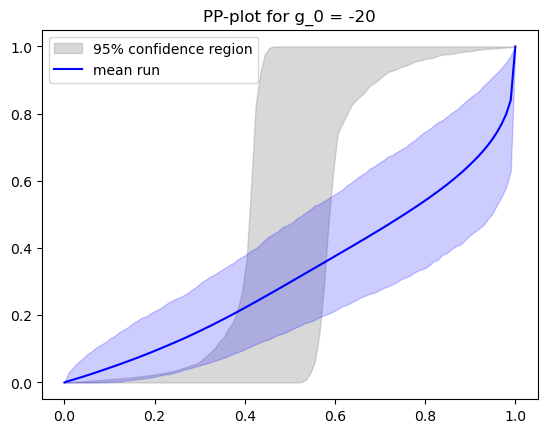

NB samples = 12500
std 0.03762175054010512
test stat:  0.13852877253240997 w_dist:  0.3077094507898661
p-value:  0.01 p_value_w:  0.0
rejected
rejected (w_dist)


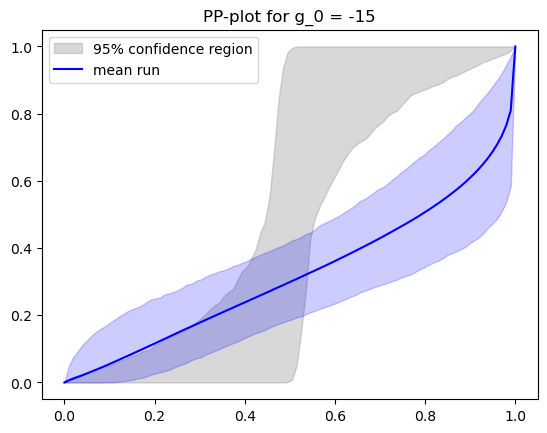

NB samples = 12500
std 0.06461828048358358
test stat:  0.15226826873747 w_dist:  0.32856780491236326
p-value:  0.0 p_value_w:  0.003
rejected
rejected (w_dist)


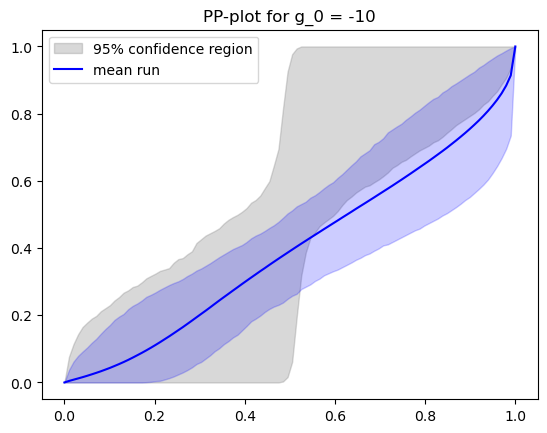

NB samples = 12500
std 0.10144582465141727
test stat:  0.10322145807230002 w_dist:  0.2748897547180062
p-value:  0.044 p_value_w:  0.042
rejected
rejected (w_dist)


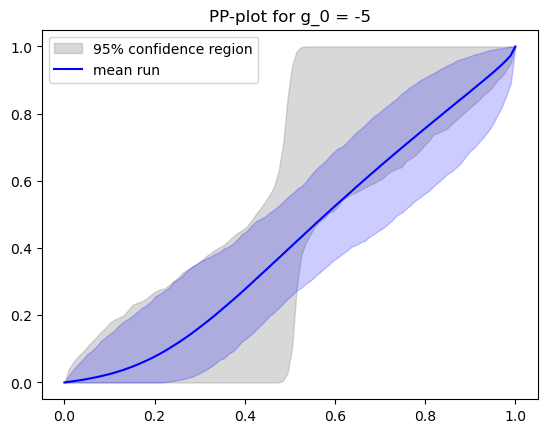

NB samples = 12500
std 0.08762334487734753
test stat:  0.07719115414830999 w_dist:  0.22514072135722688
p-value:  0.064 p_value_w:  0.068
not rejected
not rejected (w_dist)


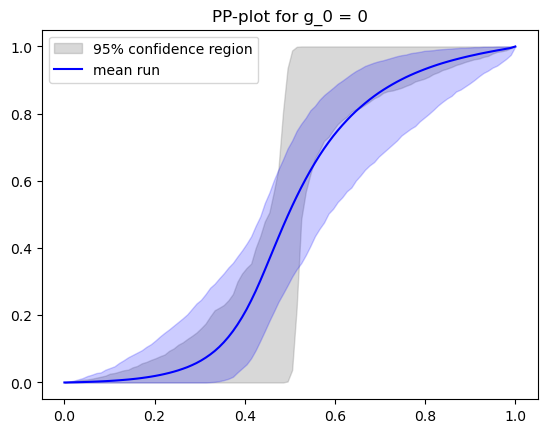

NB samples = 12500
std 0.04495914109777865
test stat:  0.03358416027641998 w_dist:  0.1239865476036044
p-value:  0.056 p_value_w:  0.035
not rejected
rejected (w_dist)


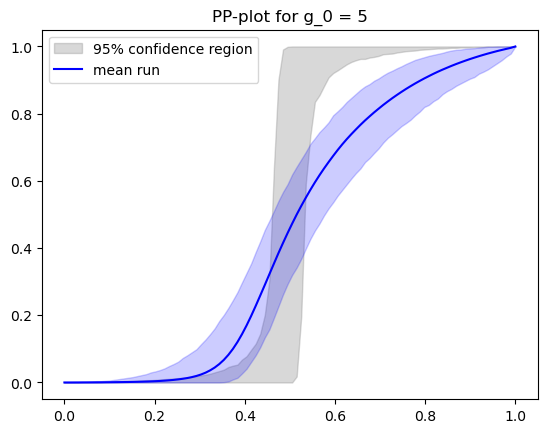

NB samples = 12500
std 0.0199339259875906
test stat:  0.037186330754830015 w_dist:  0.12740097921969287
p-value:  0.031 p_value_w:  0.002
rejected
rejected (w_dist)


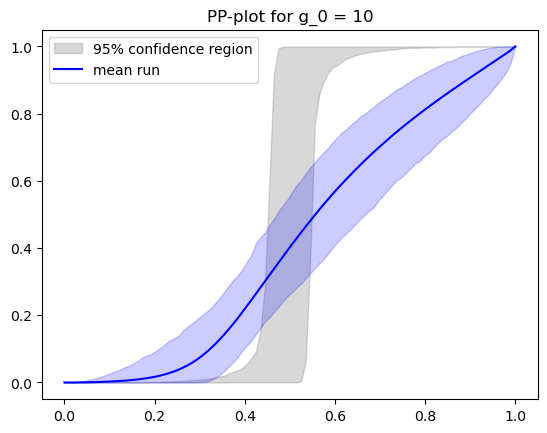

NB samples = 12500
std 0.015102651092624668
test stat:  0.05954788151641996 w_dist:  0.1800174801176908
p-value:  0.027 p_value_w:  0.0
rejected
rejected (w_dist)


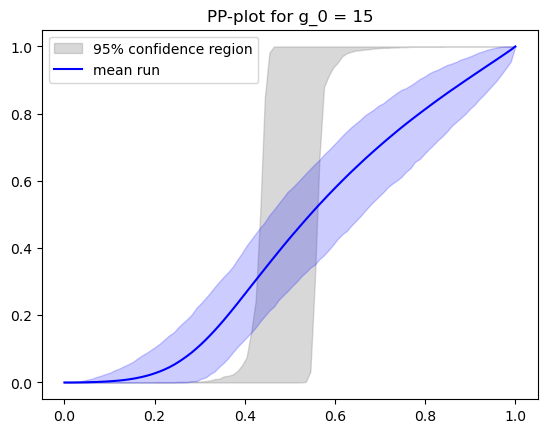

NB samples = 12500
std 0.012604776982312226
test stat:  0.06117447289822 w_dist:  0.18793643811123026
p-value:  0.043 p_value_w:  0.0
rejected
rejected (w_dist)


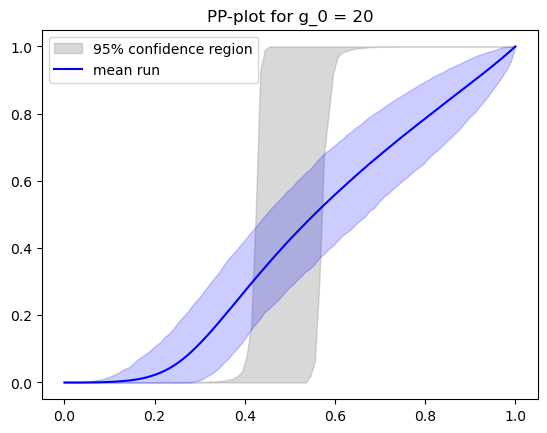

NB samples = 12500
std 0.010554482214831733
test stat:  0.06693688298919004 w_dist:  0.19860972835207183
p-value:  0.051 p_value_w:  0.0
not rejected
rejected (w_dist)


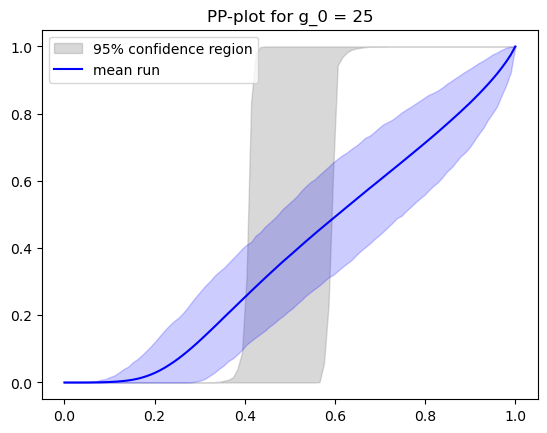

NB samples = 12500
std 0.009505943723708207
test stat:  0.08424467955691002 w_dist:  0.2265786420267903
p-value:  0.055 p_value_w:  0.003
not rejected
rejected (w_dist)


In [16]:
# Plot PP-plots and compute test-statistics/p-values
from diagnostics.pp_plots import PP_vals
from scipy.stats import wasserstein_distance

plt.rcParams.update(plt.rcParamsDefault)

test_stat = {}
w_dist_mean = {}
p_value = {}
p_value_w = {}
reject = {}
reject_w = {}

for i in range(11):

    alphas = np.linspace(0,1,100)
    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    # nb samples = 10000
    # plt.plot(alphas, pp_vals_dirac, '--', color='black')

    pp_vals_null = {}
    test_stats_null = {}
    w_dist_null = []
    for t in range(len(probas_null[0])):
        pp_vals_null[t] = pd.Series(PP_vals(probas_null[i][t], alphas))
        test_stats_null[t] = ((pp_vals_null[t]- pp_vals_dirac) ** 2).sum() / len(alphas)
        w_dist_null.append(wasserstein_distance([0.5]*1000, probas_null[i][t]))
    
    pp_vals = {}
    w_dist = []
    for t in range(1000):
        pp_vals[t] = pd.Series(PP_vals(probas[i][t], alphas))
        w_dist.append(wasserstein_distance([0.5]*1000, probas[i][t]))

    low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
    up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
    plt.fill_between(alphas, low_null, up_null, label='95% confidence region', color="grey", alpha=0.3)

    low = pd.DataFrame(pp_vals).quantile(0.05/2, axis=1)
    up = pd.DataFrame(pp_vals).quantile(1-0.05/2, axis=1)
    line = pd.DataFrame(pp_vals).mean(axis=1)
    plt.plot(alphas, line, label='mean run', color='blue')
    plt.fill_between(alphas, low, up, color="blue", alpha=0.2)
    plt.legend()
    plt.title(f'PP-plot for g_0 = {gain_list[i]}')
    plt.show()


    test_stat[i] = ((line - pp_vals_dirac) ** 2).sum() / len(alphas)
    p_value[i] = sum(1 * (test_stat[i] < pd.Series(test_stats_null))) / len(test_stats_null)

    w_dist_mean[i] = np.mean(w_dist)
    p_value_w[i] = sum(1 * (w_dist_mean[i] < pd.Series(w_dist_null))) / len(w_dist_null)
    
    print('NB samples = 12500')
    print('std', pd.DataFrame(probas_null[i]).std(axis=1).mean())
    print('test stat: ', test_stat[i], 'w_dist: ', w_dist_mean[i])
    print('p-value: ', p_value[i], 'p_value_w: ', p_value_w[i])
    if p_value[i] <= 0.05:
        print('rejected')
        reject[i] = True
    else:
        print('not rejected')
        reject[i] = False
    
    if p_value_w[i] <= 0.05:
        print('rejected (w_dist)')
        reject_w[i] = True
    else:
        print('not rejected (w_dist)')
        reject_w[i] = False

In [18]:
# Show test results in dataframe
df_results = {}
df_results['TV_dist'] = pd.DataFrame({
    'test_stat': test_stat, 
    'p_value': p_value, 
    'rejected': reject 
})
df_results['w_dist'] = pd.DataFrame({
    'test_stat': w_dist_mean, 
    'p_value': p_value_w, 
    'rejected': reject_w 
})
pd.concat({k: pd.DataFrame(v).T for k, v in df_results.items()}, axis=0)

0         1         2         3         4         5   \
TV_dist test_stat  0.116467  0.138529  0.152268  0.103221  0.077191  0.033584   
        p_value       0.039      0.01       0.0     0.044     0.064     0.056   
        rejected       True      True      True      True     False     False   
w_dist  test_stat  0.275434  0.307709  0.328568   0.27489  0.225141  0.123987   
        p_value       0.001       0.0     0.003     0.042     0.068     0.035   
        rejected       True      True      True      True     False      True   

                         6         7         8         9         10  
TV_dist test_stat  0.037186  0.059548  0.061174  0.066937  0.084245  
        p_value       0.031     0.027     0.043     0.051     0.055  
        rejected       True      True      True     False     False  
w_dist  test_stat  0.127401  0.180017  0.187936   0.19861  0.226579  
        p_value       0.002       0.0       0.0       0.0     0.003  
        rejected       True      True      True      True      True

The TV_dist fails to reject more often than w_dist, which makes w_dist more powerful (this can also be seen in the section about "precision under the null-hypothsis - cal-set choice).

### Choice of classification model and cal-set size

#### Accuracy - Shift-experiment
Results were pre-computed by running `script_margaret_local_c2st.py` with the right set-up. We still need to add results for `'lda'` and `'qda'`.

In [14]:
# Load precomputed results 
N = [1000, 2000, 5000, 10000]
dfs_mean = {}
dfs_scale = {}
for n in N:
    dfs_mean[n] = torch.load(f'../saved_experiments/JR-NMM/normal_4d/lc2st_eval_clfs/df_mean_{n}.pkl')
    dfs_scale[n] = torch.load(f'../saved_experiments/JR-NMM/normal_4d/lc2st_eval_clfs/df_scale_{n}.pkl')

##### Mean-shift

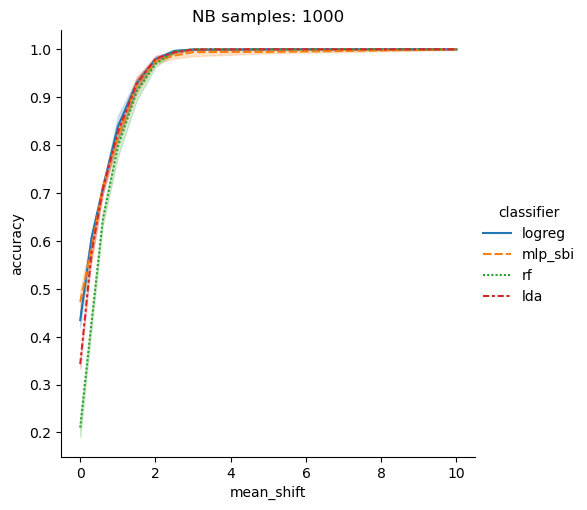

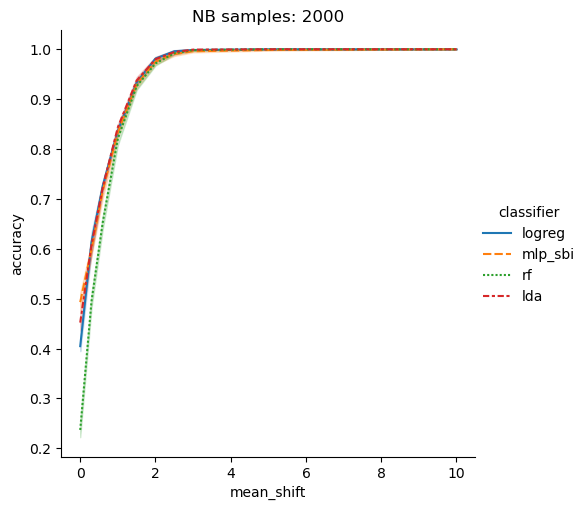

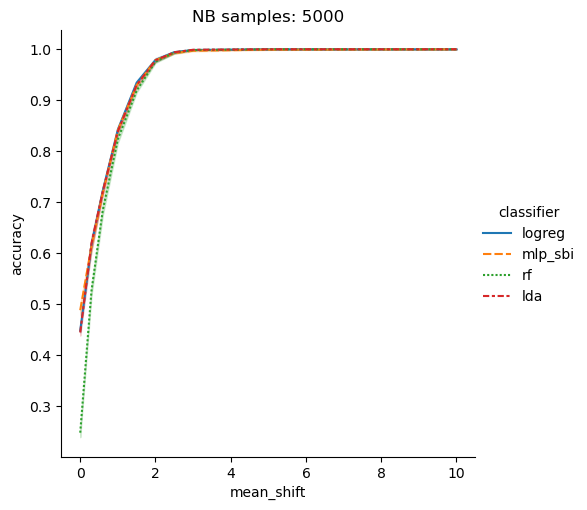

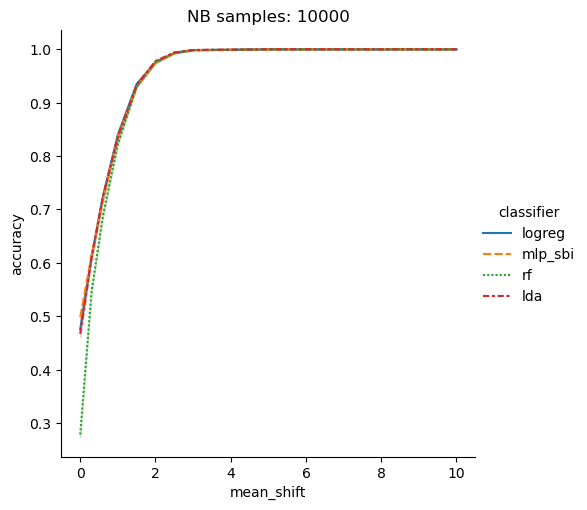

In [15]:
import seaborn as sns
for n in N:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

##### Scale-shift


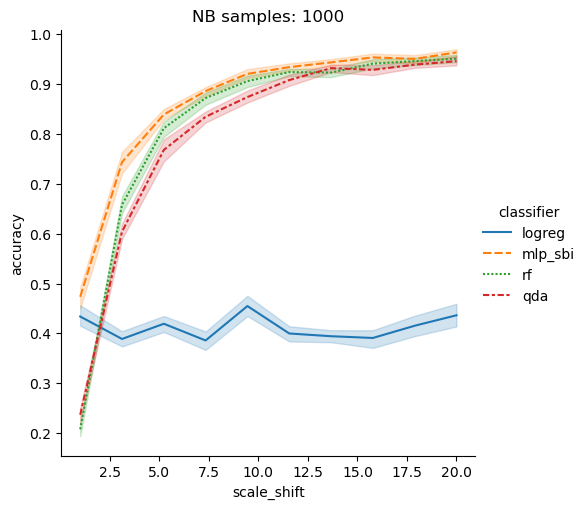

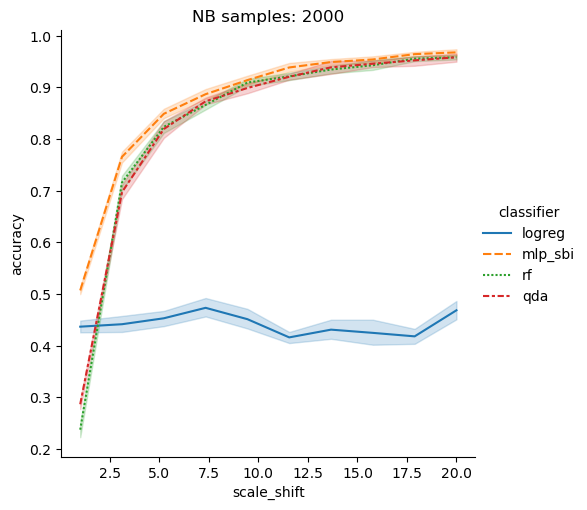

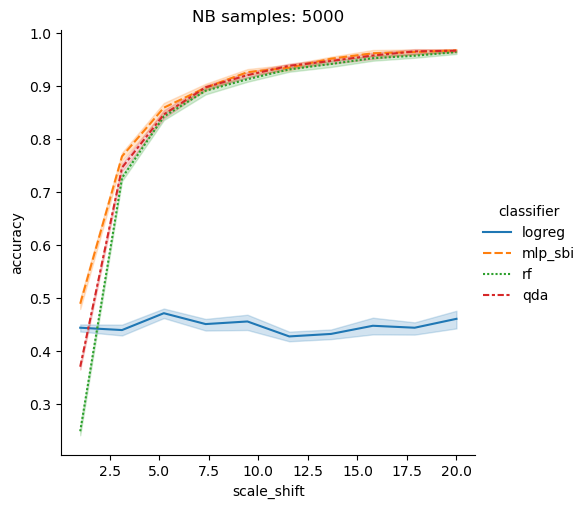

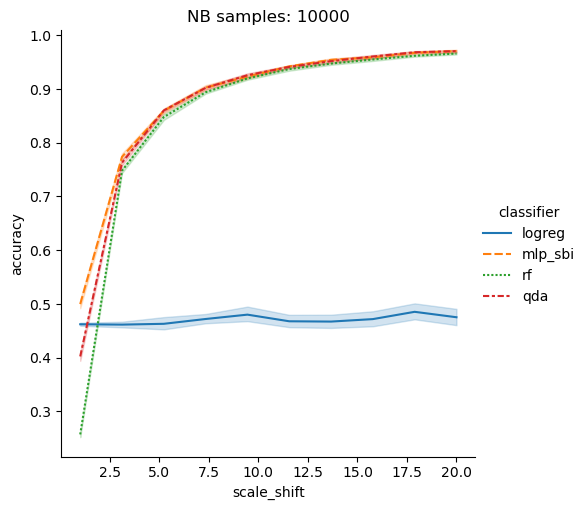

In [16]:
for n in N:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

Why does QDA not start at 0.5 in this case?

#### Precision under the null hypothesis - cal-set size
Results were pre-computed by running `script_margaret_local_c2st.py` with the right set-up.


TV_dist



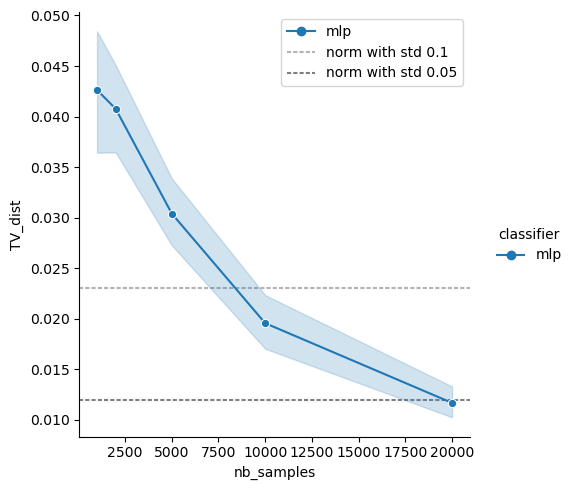


w_dist



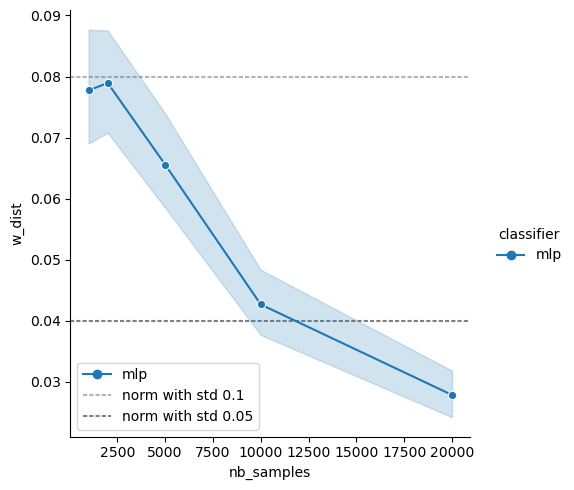


TV_dist



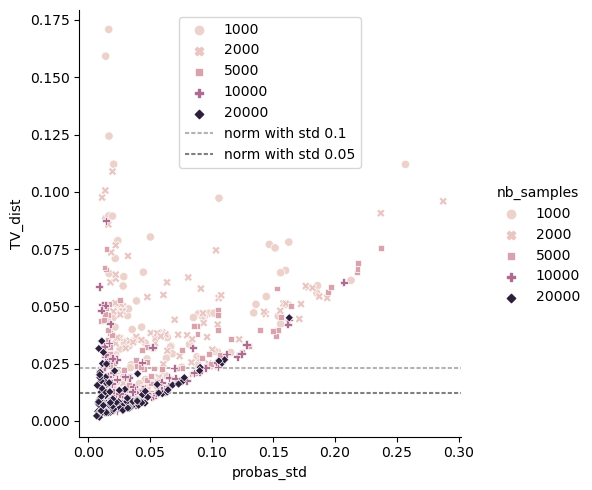


w_dist



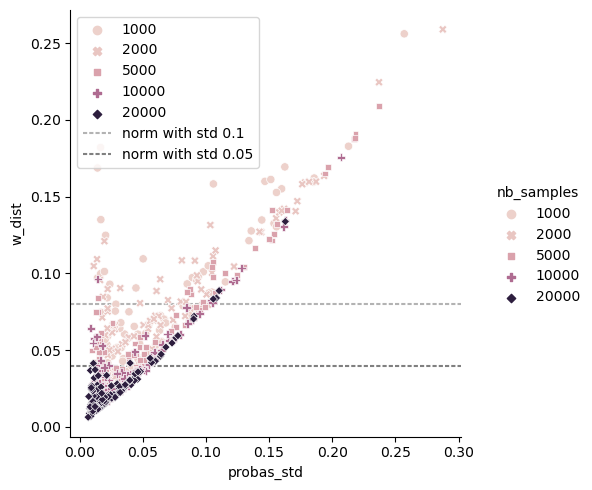

In [5]:
import seaborn as sns 

dfs = []
for n in [1000, 2000, 5000, 10000, 20000]: #, 50000]:
    dfs.append(torch.load(f'../saved_experiments/JR-NMM/normal_4d/lc2st_eval_clfs/df_null_std_cv_n_[{n}]_ntrials_100_Tstats_wdist.pkl'))

df = pd.concat(dfs, ignore_index=True)

for T, y1, y2 in zip(['TV_dist', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    print()
    print(T)
    print()
    g = sns.relplot(
            data=df, x="nb_samples", y=T,
            hue="classifier", style="classifier", kind="line", markers='o'
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()


for T, y1, y2 in zip(['TV_dist', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    print()
    print(T)
    print()
    g = sns.relplot(
            data=df, x="probas_std", y=T,
            hue="nb_samples", style="nb_samples", kind="scatter", 
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()
    df[df[T]<=y1]['probas_std'].max(), df[df[T]<=y2]['probas_std'].max()

Results:
- plot 1 - TV_dist: the wanted test statistics are obtained for a sample size of 10_000 (for 0.1 std) and 20_000 (for 0.05 std)
- plot 2 - w_dist: the wanted test statistics are obtained for a sample size of ~12_500 (for 0.05 std) and always fpr 0.1 std
- plot 3/4: Larger sample sizes ensure small test statistics for small stds (closer to theory). For the TV_dist, there are still data points with predicted stds that are above the theory (points with test stat below the line but with std larger than 0.05/0.1), this is not really the case for w_dist. 

1. The wasserstein distance seems to lead to statistically more powerful tests (less data needed to get narrow confidence regions).

2. What sample size do we chose? 
- the shift experiment showed us that good accuracy is obtained (with precision) for sample sizes above 5000 (cf. scale shift: smooth accuracy curve with narrow CV-std and where mlp consistently above rf). We would say 10000 is appropriate. 
- looking at the precision under the null-hypothesis, 10000 seems to lead to results with still pretty high and dispersed stds / test-statistics. I would propose a sample size of 
    -  12500 if we are short on simulations (here the w_dist test stat is already quite close to the theoretical test statistic of the 0.05 std gaussian), 
    - 20000 if simulations are not a problem (to get even more precise results).